In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

In [2]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [4]:
image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

83281/83281 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


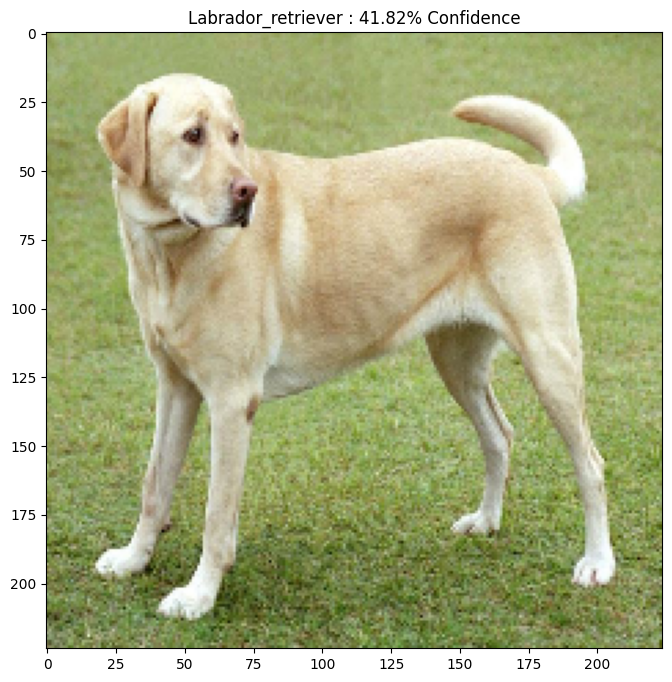

In [5]:
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

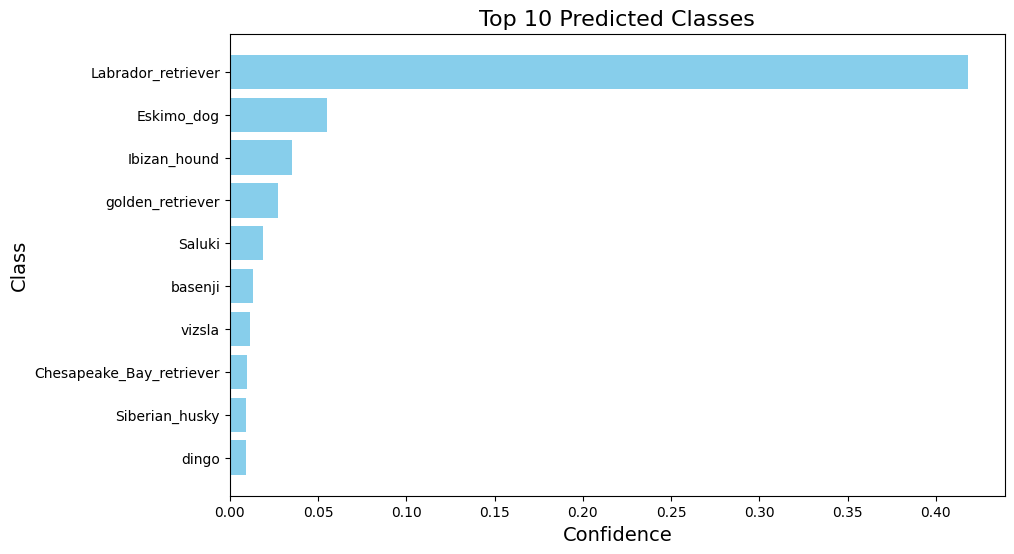

In [6]:
# Get the top 5 predicted classes and their probabilities
top_predictions = decode_predictions(image_probs, top=10)[0]

# Extract class names and their confidence scores
classes = [pred[1] for pred in top_predictions]
confidences = [pred[2] for pred in top_predictions]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.barh(classes, confidences, color='skyblue')
plt.xlabel('Confidence', fontsize=14)
plt.ylabel('Class', fontsize=14)
plt.title('Top 10 Predicted Classes', fontsize=16)
plt.gca().invert_yaxis()  # To show the highest confidence at the top
plt.show()

In [7]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

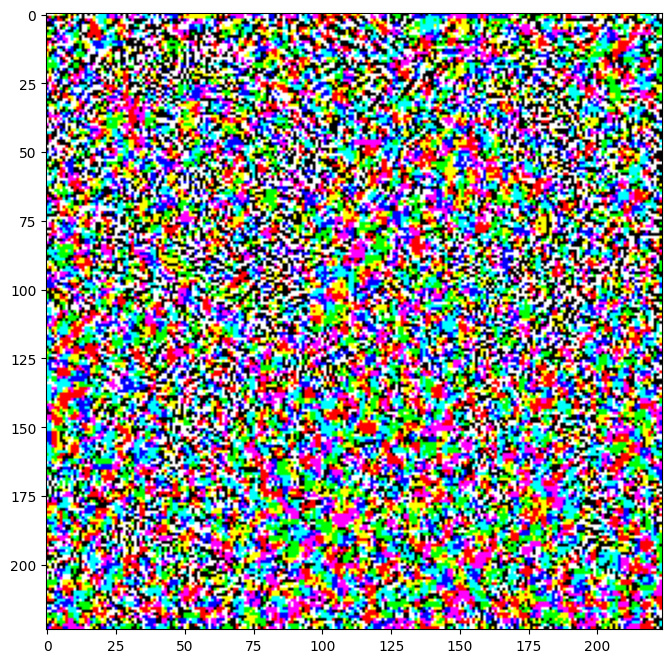

In [8]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [9]:
def display_images(image, description):
  _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.2f}% Confidence'.format(description,
                                                   label, confidence*100))
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


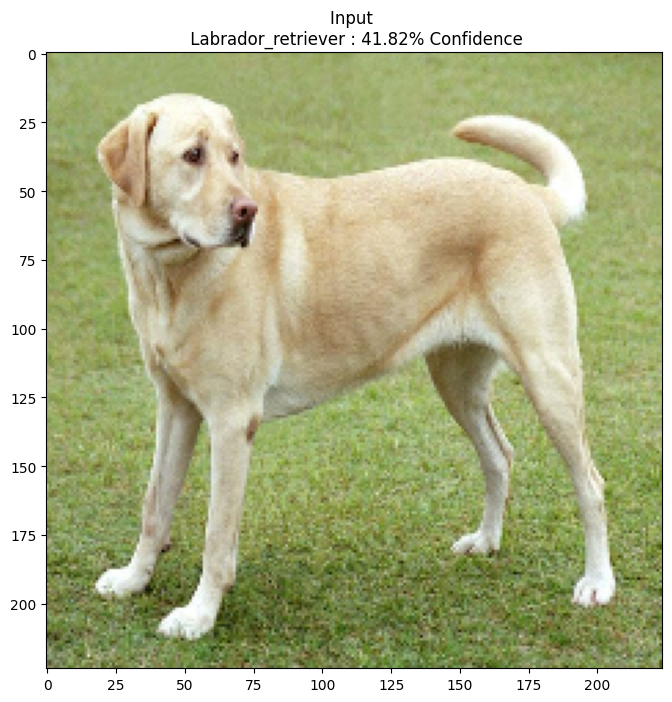

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


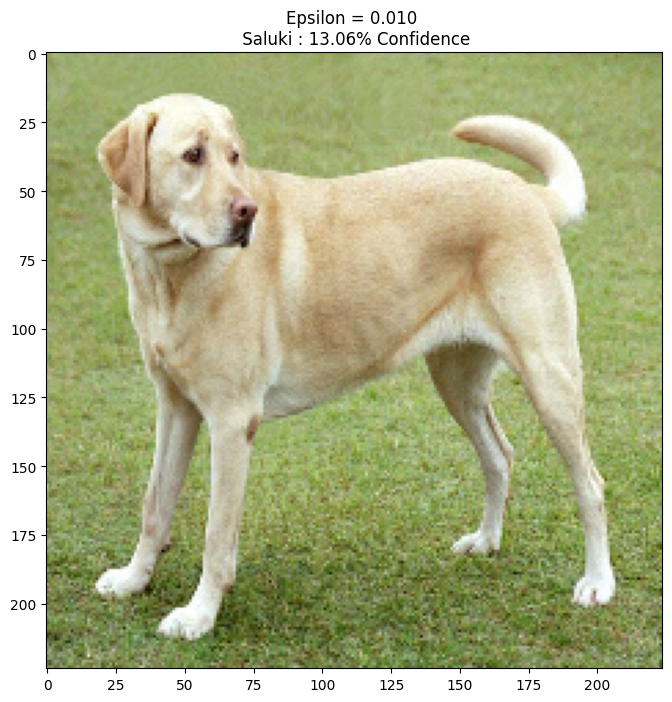

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


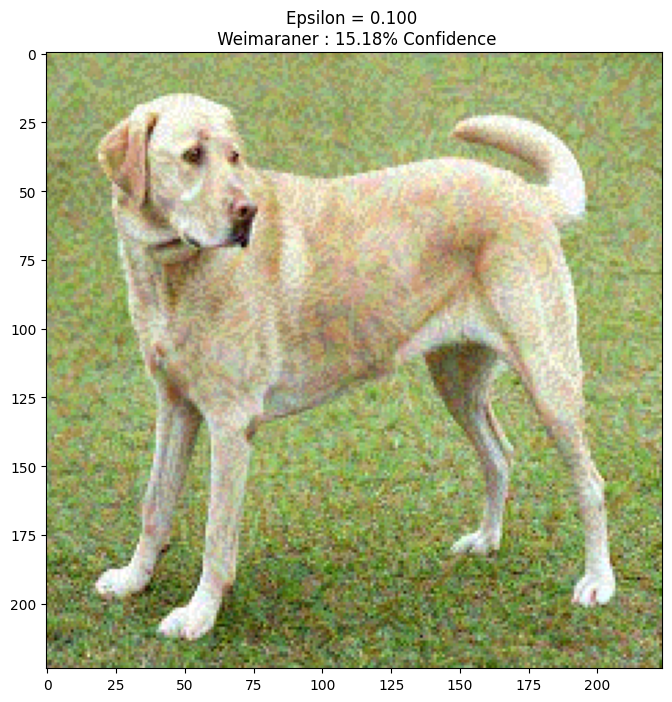

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


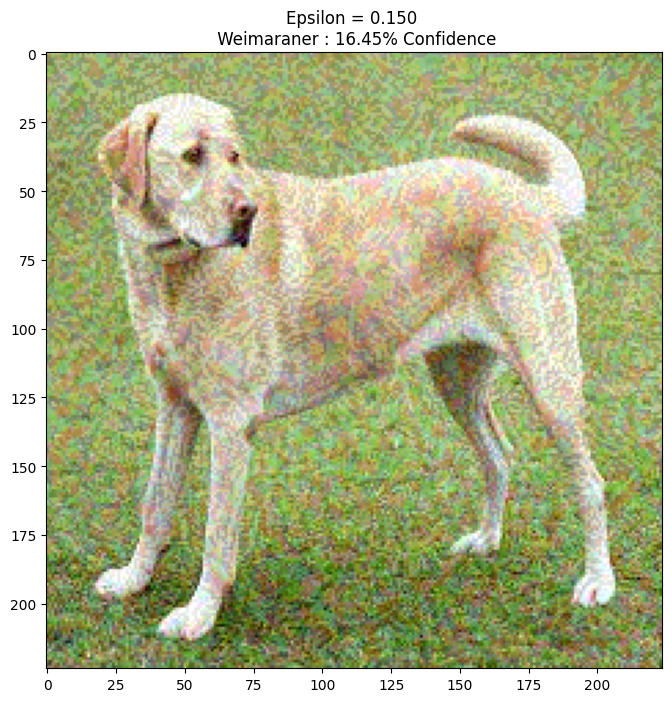

In [10]:
epsilons = [0, 0.01, 0.1, 0.15]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  display_images(adv_x, descriptions[i])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


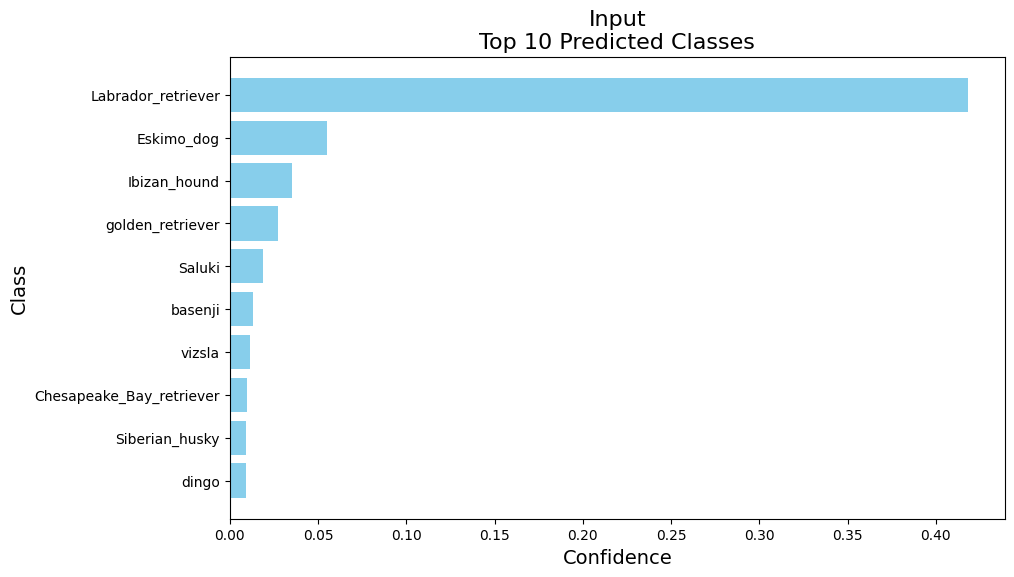

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


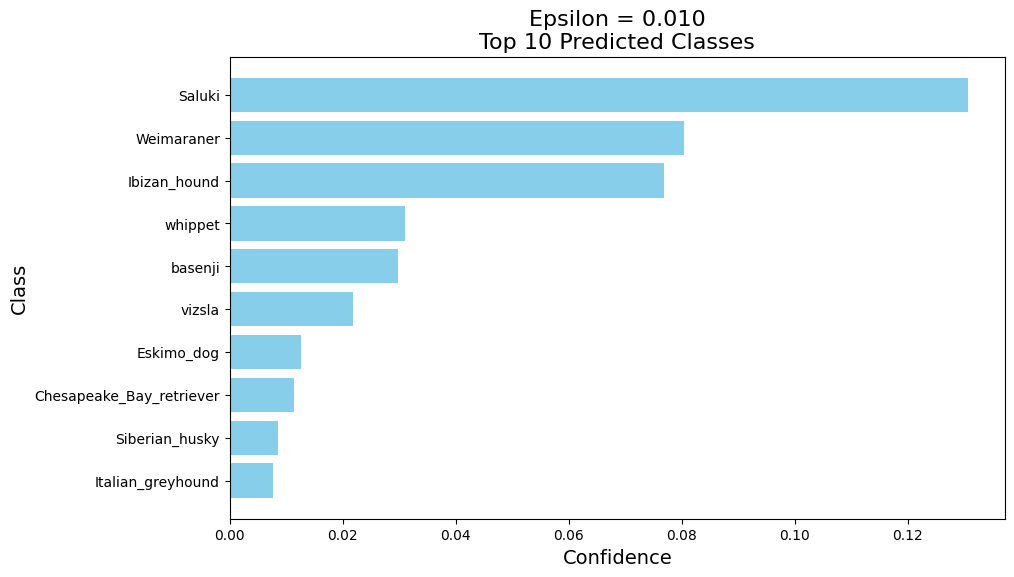

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


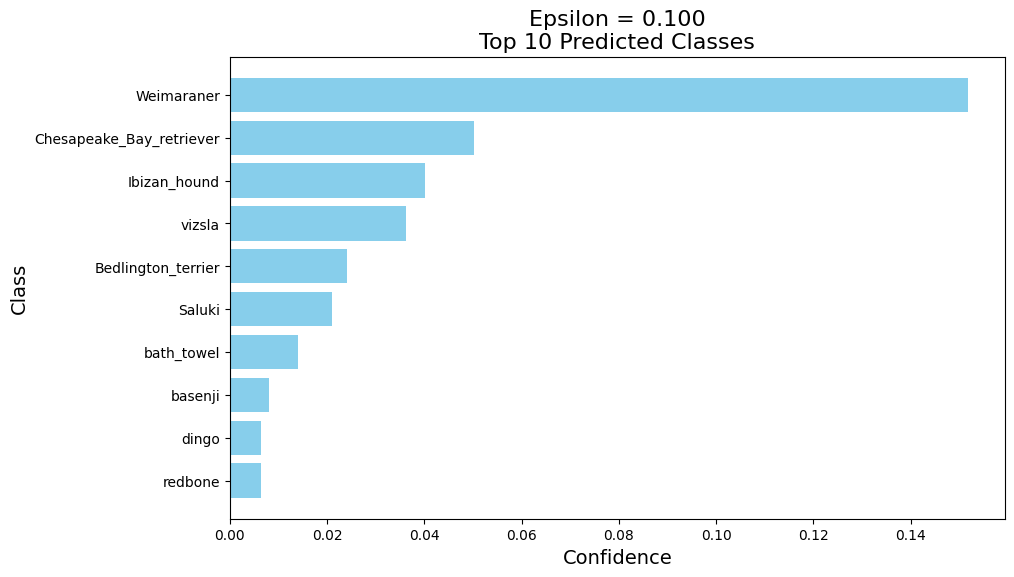

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


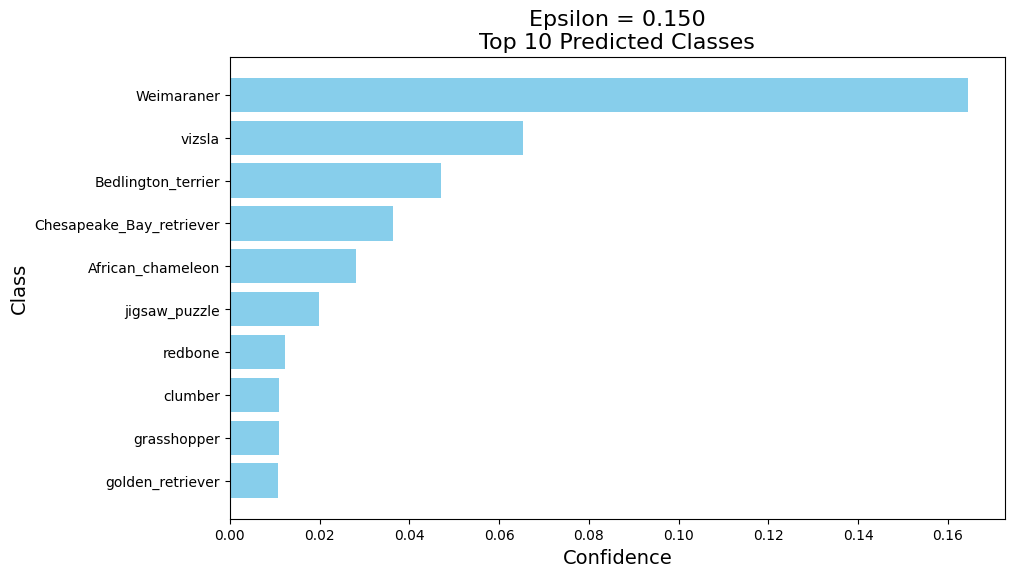

In [11]:
# Function to display histogram of predictions
def display_prediction_histogram(image, description):
    # Get predictions for the current image
    image_probs = pretrained_model.predict(image)
    top_predictions = decode_predictions(image_probs, top=10)[0]

    # Extract class names and their confidence scores
    classes = [pred[1] for pred in top_predictions]
    confidences = [pred[2] for pred in top_predictions]

    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.barh(classes, confidences, color='skyblue')
    plt.xlabel('Confidence', fontsize=14)
    plt.ylabel('Class', fontsize=14)
    plt.title('{}\nTop 10 Predicted Classes'.format(description), fontsize=16)
    plt.gca().invert_yaxis()
    plt.show()

for i, eps in enumerate(epsilons):
    adv_x = image + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    description = descriptions[i]

    # Display histogram for each adversarial image
    display_prediction_histogram(adv_x, description)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


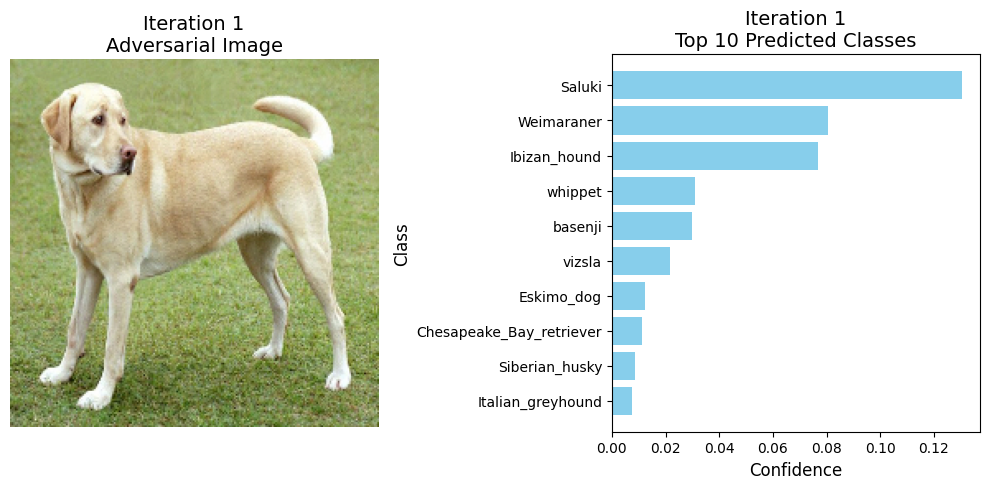

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


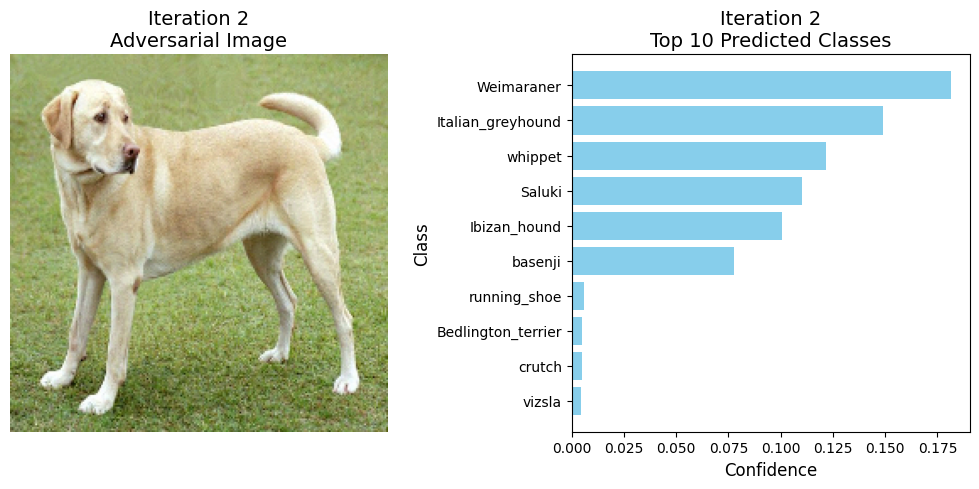

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


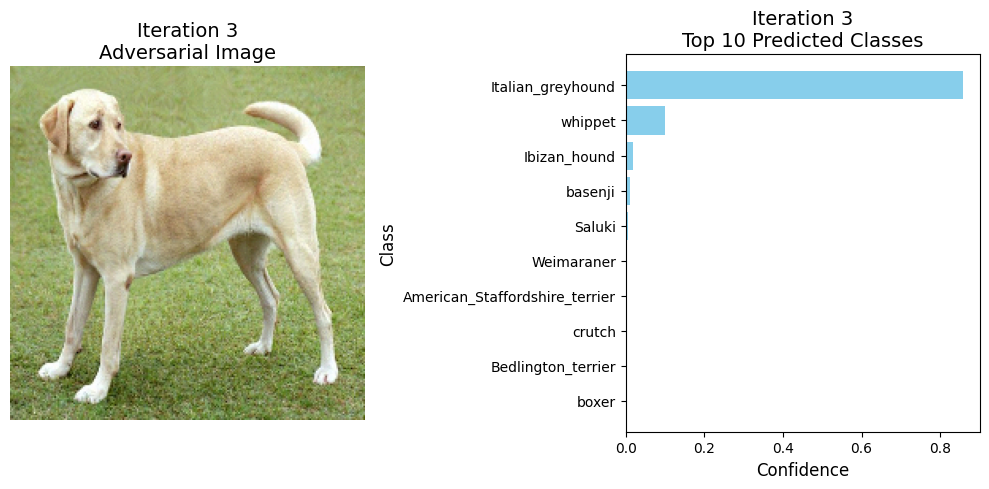

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


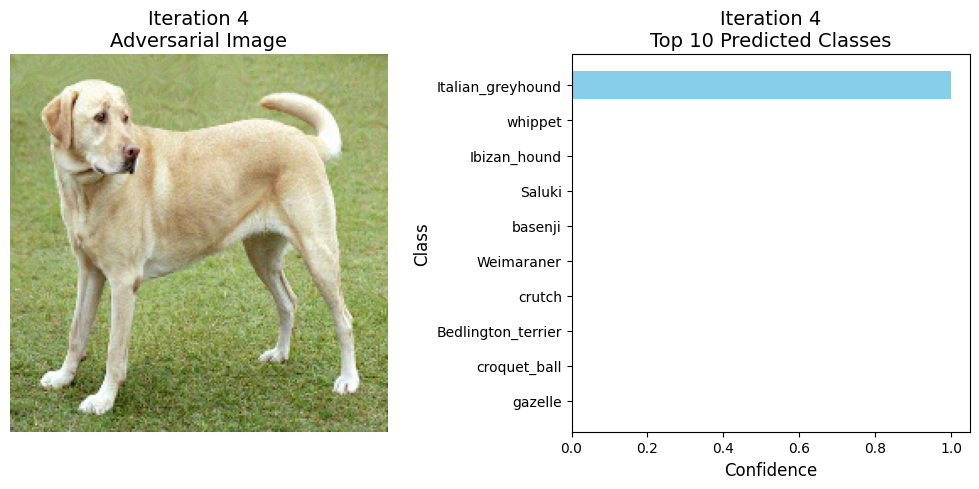

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


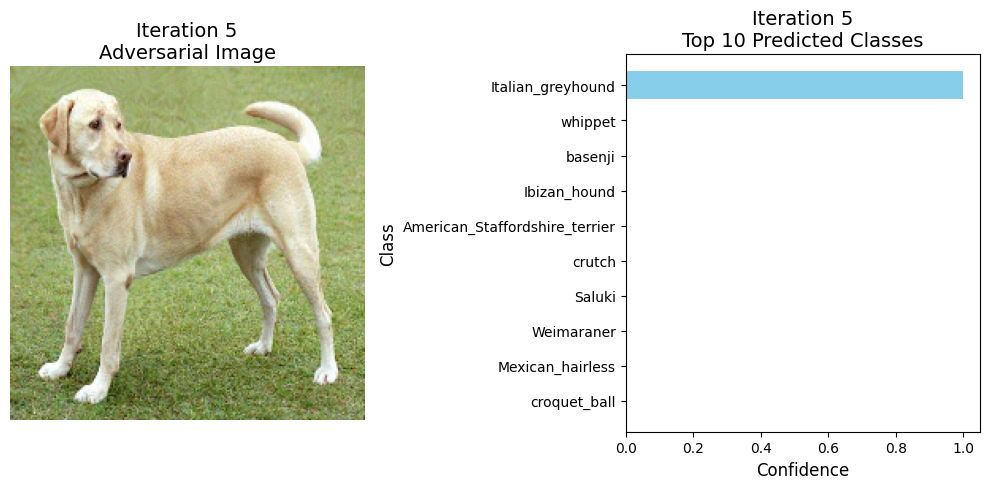

In [12]:
# Loss function
loss_object = tf.keras.losses.CategoricalCrossentropy()

# Basic Iterative Method (BIM) attack
def basic_iterative_method(model, image, label, epsilon, alpha, num_iterations):
    adv_image = image
    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(adv_image)
            prediction = model(adv_image)
            loss = loss_object(label, prediction)

        # Calculate gradient
        gradient = tape.gradient(loss, adv_image)
        signed_grad = tf.sign(gradient)

        # Update adversarial image
        adv_image = adv_image + alpha * signed_grad
        adv_image = tf.clip_by_value(adv_image, -1, 1)  # Keep in valid range

        # Display the adversarial image and histogram
        display_image_and_histogram(adv_image, f"Iteration {i + 1}")
    return adv_image

# Display adversarial image and prediction histogram
def display_image_and_histogram(image, description):
    # Display adversarial image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image[0] * 0.5 + 0.5)  # Convert range [-1, 1] to [0, 1]
    plt.title(f"{description}\nAdversarial Image", fontsize=14)
    plt.axis('off')

    # Display histogram of predictions
    image_probs = pretrained_model.predict(image)
    top_predictions = decode_predictions(image_probs, top=10)[0]

    classes = [pred[1] for pred in top_predictions]
    confidences = [pred[2] for pred in top_predictions]

    plt.subplot(1, 2, 2)
    plt.barh(classes, confidences, color='skyblue')
    plt.xlabel('Confidence', fontsize=12)
    plt.ylabel('Class', fontsize=12)
    plt.title(f'{description}\nTop 10 Predicted Classes', fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Prepare the label
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

epsilon = 0.1
alpha = 0.01
num_iterations = 5

# Perform BIM attack and display images + histograms
adv_image = basic_iterative_method(pretrained_model, image, label, epsilon, alpha, num_iterations)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


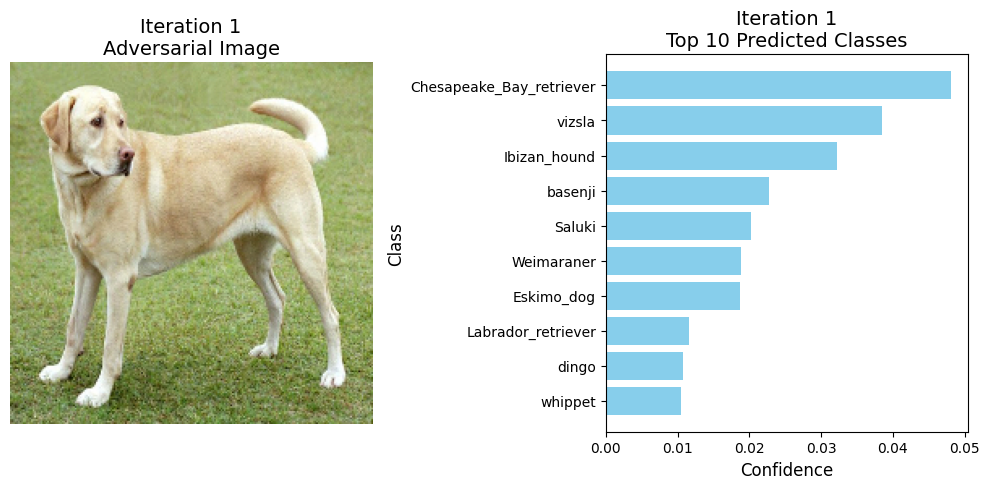

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


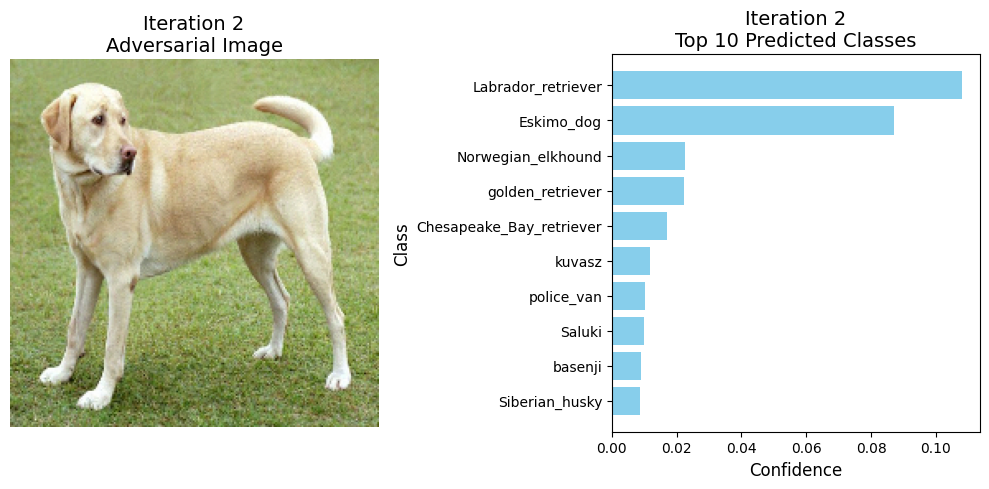

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


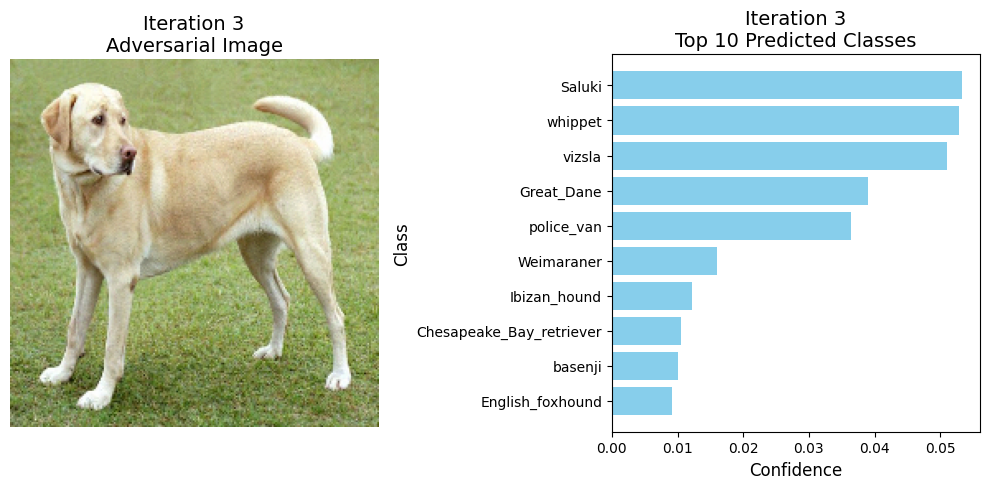

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


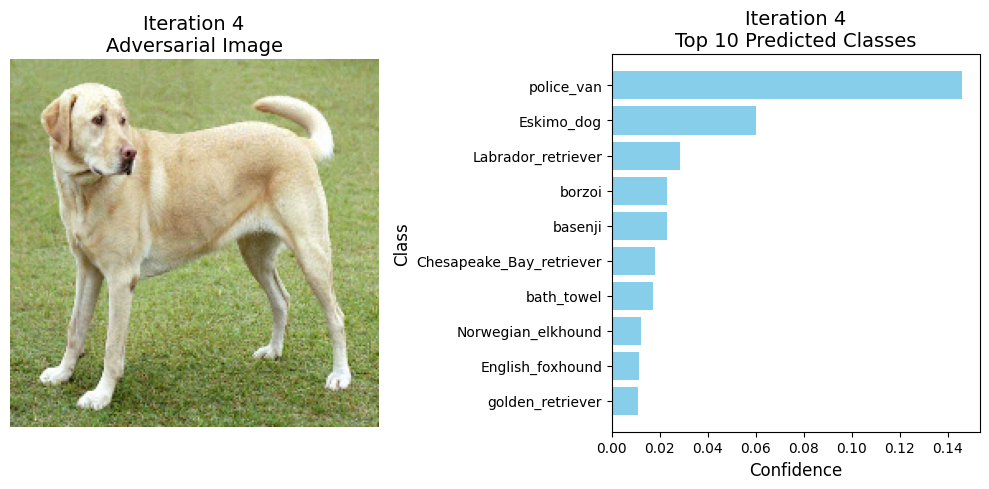

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


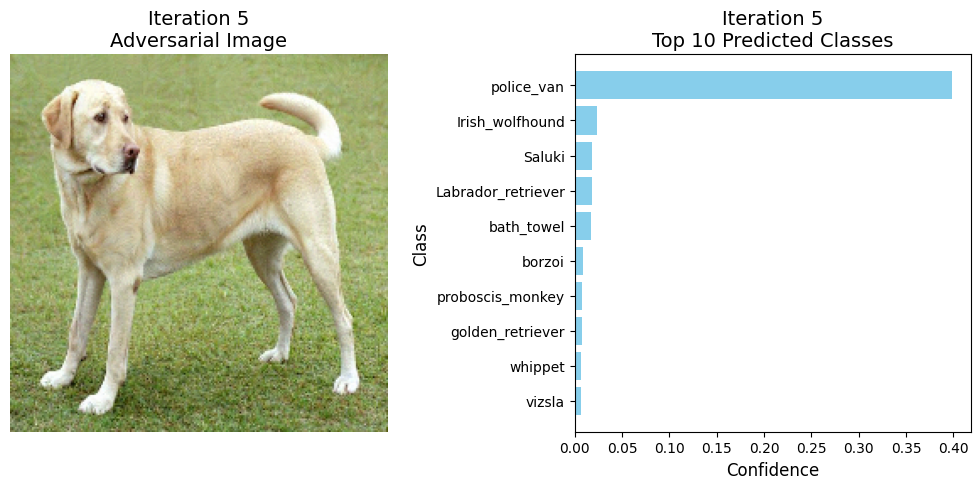

In [15]:
# Define the targeted attack function
def targeted_attack(model, image, target_index, alpha, num_iterations):
    # Create a one-hot label for the targeted class
    target_label = tf.one_hot(target_index, model.output_shape[-1])
    target_label = tf.reshape(target_label, (1, model.output_shape[-1]))

    adv_image = tf.identity(image)
    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            tape.watch(adv_image)
            prediction = model(adv_image)
            # Loss function: cross-entropy towards the target class
            loss = tf.keras.losses.CategoricalCrossentropy()(target_label, prediction)

        # Calculate gradient
        gradient = tape.gradient(loss, adv_image)
        signed_grad = tf.sign(gradient)

        adv_image = adv_image - alpha * signed_grad
        adv_image = tf.clip_by_value(adv_image, -1, 1)  # Keep in valid range [-1, 1]

        display_image_and_histogram(adv_image, f"Iteration {i + 1}")

    return adv_image

# Display adversarial image and prediction histogram
def display_image_and_histogram(image, description):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image[0] * 0.5 + 0.5)
    plt.title(f"{description}\nAdversarial Image", fontsize=14)
    plt.axis('off')

    image_probs = pretrained_model.predict(image)
    top_predictions = decode_predictions(image_probs, top=10)[0]

    classes = [pred[1] for pred in top_predictions]
    confidences = [pred[2] for pred in top_predictions]

    plt.subplot(1, 2, 2)
    plt.barh(classes, confidences, color='skyblue')
    plt.xlabel('Confidence', fontsize=12)
    plt.ylabel('Class', fontsize=12)
    plt.title(f'{description}\nTop 10 Predicted Classes', fontsize=14)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

target_class_index = 734
alpha = 0.01
num_iterations = 5

adv_image = targeted_attack(pretrained_model, image, target_class_index, alpha, num_iterations)

In [14]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import numpy as np

all_classes = decode_predictions(np.expand_dims(np.arange(1000), axis=0), top=1000)[0]

target_class_name = "Mexican_hairless"
target_class_index = None
for idx, (_, class_name, _) in enumerate(all_classes):
    if class_name == target_class_name:
        target_class_index = idx
        break

if target_class_index is not None:
    print(f"Target class '{target_class_name}' has index: {target_class_index}")
else:
    print("Target class not found!")


Target class 'Mexican_hairless' has index: 731
